## Benson exploratory data analysis

In [2]:
from collections import defaultdict
from dateutil.parser import parse
from datetime import datetime
from datetime import date
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Image

%matplotlib inline

In [3]:
# various options in pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 25)
pd.set_option('display.precision', 3)

In [4]:
def read_mta(file_nums):
    path ='http://web.mta.info/developers/data/nyct/turnstile/turnstile_'
    allFiles = []
    for i in file_nums:
        allFiles.append(path + i + ".txt")
    df_list = [pd.read_csv(file) for file in allFiles]
    df = pd.concat(df_list)
    df.columns = df.columns.str.strip()
    return df

In [5]:
# March data
df = read_mta(['170325', '170318', '170311', '170304'])

In [6]:
df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

In [7]:
# remove duplicates
df = df[df.DESC != 'RECOVR AUD']
df = df[df.TIME != '04:01:13']
# Sanity check to verify that "C/A", "UNIT", "SCP", "STATION", "DATE_TIME" is unique
(df
 .groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE', 'TIME'])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head()

,C/A,UNIT,SCP,STATION,DATE,TIME,ENTRIES
0,A002,R051,02-00-00,59 ST,02/25/2017,03:00:00,1
517918,R143,R032,02-03-01,TIMES SQ-42 ST,03/11/2017,15:00:00,1
517909,R143,R032,02-03-01,TIMES SQ-42 ST,03/09/2017,23:00:00,1
517910,R143,R032,02-03-01,TIMES SQ-42 ST,03/10/2017,03:00:00,1
517911,R143,R032,02-03-01,TIMES SQ-42 ST,03/10/2017,07:00:00,1


In [8]:
# data is at a turnstile level
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/18/2017,00:00:00,REGULAR,6095917,2065975
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/18/2017,04:00:00,REGULAR,6095980,2065977
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/18/2017,08:00:00,REGULAR,6096012,2066004
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/18/2017,12:00:00,REGULAR,6096165,2066103
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/18/2017,16:00:00,REGULAR,6096540,2066168


In [9]:
df['DATETIME'] = pd.to_datetime(df.DATE + ' ' + df.TIME)

In [10]:
df = df.set_index(['DATETIME'])
#df.head()

In [11]:
# filter dataset to 4am to noon
morning = df.between_time('04:00:00', '12:00:00')
morning.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
DATETIME,,,,,,,,,,,
2017-03-18 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/18/2017,04:00:00,REGULAR,6095980,2065977
2017-03-18 08:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/18/2017,08:00:00,REGULAR,6096012,2066004
2017-03-18 12:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/18/2017,12:00:00,REGULAR,6096165,2066103
2017-03-19 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/19/2017,04:00:00,REGULAR,6097250,2066240
2017-03-19 08:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/19/2017,08:00:00,REGULAR,6097260,2066259


In [12]:
# subtract max from min for each turnstile to get exits
morning_turn = (morning.groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE'])['EXITS'].max()\
           -morning.groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE'])['EXITS'].min()).reset_index()

In [13]:
#explore outliers
morning_turn['EXITS'].describe()

count    1.309e+05
mean     7.928e+02
std      8.658e+04
min      0.000e+00
25%      1.700e+01
50%      9.600e+01
75%      2.760e+02
max      1.685e+07
Name: EXITS, dtype: float64

In [14]:
# oddly high value for 47-50
morning_turn.loc[morning_turn['STATION'] == '47-50 STS ROCK']['EXITS'].sort_values(ascending = True).tail(10)

60327        2892
60332        2895
60325        2943
60330        2947
60361        2971
60333        2994
60354        3312
60326        3471
60941    15447834
60913    15448026
Name: EXITS, dtype: int64

In [15]:
morning_turn['EXITS'].sort_values(ascending = True).tail(30)

101558        5627
101561        5629
101554        5632
101553        5791
101559        5803
14729        11936
25330        13257
75281        14315
75975        26042
80779        30254
81094        31664
78655        37722
            ...   
73918        89231
36326       108121
78461       246263
73632       822530
79152       933403
127543     1374207
78488      1573110
100987     7503729
100978    12562196
60941     15447834
60913     15448026
68904     16850624
Name: EXITS, dtype: int64

In [16]:
# removing values that appear to be counter resets
morning_turn = morning_turn[morning_turn.EXITS <= 11000]

In [17]:
morning_turn.head()
#morning_turn.shape

,C/A,UNIT,SCP,STATION,DATE,EXITS
0,A002,R051,02-00-00,59 ST,02/25/2017,103
1,A002,R051,02-00-00,59 ST,02/26/2017,65
2,A002,R051,02-00-00,59 ST,02/27/2017,255
3,A002,R051,02-00-00,59 ST,02/28/2017,386
4,A002,R051,02-00-00,59 ST,03/01/2017,346


In [18]:
# add up total morning exits per station
morning_station = morning_turn.groupby(['STATION', 'DATE']).sum().reset_index()
morning_station['DATE'] = pd.to_datetime(morning_station['DATE'])
morning_station.head()

,STATION,DATE,EXITS
0,1 AV,2017-02-25,2499
1,1 AV,2017-02-26,1817
2,1 AV,2017-02-27,6897
3,1 AV,2017-02-28,7145
4,1 AV,2017-03-01,7222


In [19]:
# summing for whole month
morning_month = morning_station.groupby(['STATION'])['EXITS'].sum().reset_index()
morning_month = morning_month.set_index('STATION')

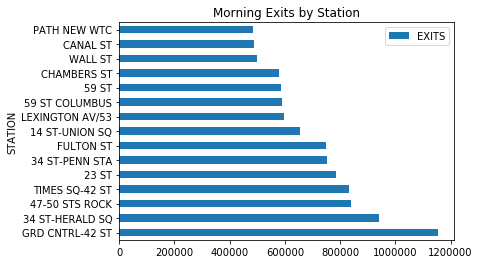

In [20]:
# determine busiest stations
topsts = morning_month.sort_values('EXITS', ascending=False).head(15)
topsts.head()
topsts.plot(kind='barh', title='Morning Exits by Station')

### Grand Central Station analysis

Station chosen because it has the greatest number of morning exits. What do exit patterns look like over the course of the month (at four hour increments). Weekly patterns?

In [21]:
# df.head()

In [22]:
# limit to Grand Central at turnstile level
grdcentral = df[df['STATION'] == 'GRD CNTRL-42 ST']

In [23]:
grdcentral.shape

(10144, 11)

In [24]:
grdcentral.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
DATETIME,,,,,,,,,,,
2017-03-18 01:00:00,R236,R045,00-00-00,GRD CNTRL-42 ST,4567S,IRT,03/18/2017,01:00:00,REGULAR,747519,2221855
2017-03-18 05:00:00,R236,R045,00-00-00,GRD CNTRL-42 ST,4567S,IRT,03/18/2017,05:00:00,REGULAR,747528,2221890
2017-03-18 09:00:00,R236,R045,00-00-00,GRD CNTRL-42 ST,4567S,IRT,03/18/2017,09:00:00,REGULAR,747552,2222107
2017-03-18 13:00:00,R236,R045,00-00-00,GRD CNTRL-42 ST,4567S,IRT,03/18/2017,13:00:00,REGULAR,747659,2222859
2017-03-18 17:00:00,R236,R045,00-00-00,GRD CNTRL-42 ST,4567S,IRT,03/18/2017,17:00:00,REGULAR,747888,2223831


In [25]:
turnstiles = grdcentral['SCP'].unique()

In [26]:
masked_dfs = []
for i in turnstiles:
    mask = grdcentral[((grdcentral["C/A"] == "R236") & 
    (grdcentral["UNIT"] == "R045") & 
    (grdcentral["SCP"] ==  i) & 
    (grdcentral["STATION"] == "GRD CNTRL-42 ST"))]
            
    mask['DIFFS'] = mask['EXITS'].diff()
    masked_dfs.append(mask)

/Users/braeburn/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [27]:
exits_turn = pd.concat(masked_dfs)

In [28]:
exits_turn.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DIFFS
DATETIME,,,,,,,,,,,,
2017-03-18 01:00:00,R236,R045,00-00-00,GRD CNTRL-42 ST,4567S,IRT,03/18/2017,01:00:00,REGULAR,747519,2221855,NaN
2017-03-18 05:00:00,R236,R045,00-00-00,GRD CNTRL-42 ST,4567S,IRT,03/18/2017,05:00:00,REGULAR,747528,2221890,35.0
2017-03-18 09:00:00,R236,R045,00-00-00,GRD CNTRL-42 ST,4567S,IRT,03/18/2017,09:00:00,REGULAR,747552,2222107,217.0
2017-03-18 13:00:00,R236,R045,00-00-00,GRD CNTRL-42 ST,4567S,IRT,03/18/2017,13:00:00,REGULAR,747659,2222859,752.0
2017-03-18 17:00:00,R236,R045,00-00-00,GRD CNTRL-42 ST,4567S,IRT,03/18/2017,17:00:00,REGULAR,747888,2223831,972.0


In [29]:
#remove NaN values and negative values (i.e. counter resets)
exits_turn.dropna(inplace=True)
exits_turn = exits_turn[exits_turn['DIFFS'] >= 0]

In [30]:
# now have turnstile exits per four period (diffs column)
exits_turn.tail()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DIFFS
DATETIME,,,,,,,,,,,,
2017-03-03 04:00:00,R236,R045,00-06-01,GRD CNTRL-42 ST,4567S,IRT,03/03/2017,04:00:00,REGULAR,5334942,3221500,0.0
2017-03-03 08:00:00,R236,R045,00-06-01,GRD CNTRL-42 ST,4567S,IRT,03/03/2017,08:00:00,REGULAR,5334969,3221541,41.0
2017-03-03 12:00:00,R236,R045,00-06-01,GRD CNTRL-42 ST,4567S,IRT,03/03/2017,12:00:00,REGULAR,5335160,3221686,145.0
2017-03-03 16:00:00,R236,R045,00-06-01,GRD CNTRL-42 ST,4567S,IRT,03/03/2017,16:00:00,REGULAR,5335747,3221811,125.0
2017-03-03 20:00:00,R236,R045,00-06-01,GRD CNTRL-42 ST,4567S,IRT,03/03/2017,20:00:00,REGULAR,5337059,3221856,45.0


In [31]:
# add exits across turnstiles by time
exits_turn = exits_turn.reset_index()
ct = exits_turn.groupby(['DATETIME'])['DIFFS'].sum().reset_index()

In [32]:
ct.set_index(['DATETIME'], inplace=True)
ct.head()

,DIFFS
DATETIME,
2017-02-25 04:00:00,25.0
2017-02-25 08:00:00,438.0
2017-02-25 12:00:00,1960.0
2017-02-25 16:00:00,2241.0
2017-02-25 20:00:00,2655.0


In [33]:
we1 = ct[(ct.index > '2017-02-25 00:00:00') & (ct.index < '2017-02-27 05:00:00')]
wd1 = ct[(ct.index > '2017-02-27 00:00:00') & (ct.index < '2017-03-04 05:00:00')]
we2 = ct[(ct.index > '2017-03-04 00:00:00') & (ct.index < '2017-03-06 05:00:00')]
wd2 = ct[(ct.index > '2017-03-06 00:00:00') & (ct.index < '2017-03-11 05:00:00')]
we3 = ct[(ct.index > '2017-03-11 00:00:00') & (ct.index < '2017-03-13 05:00:00')]
wd3 = ct[(ct.index > '2017-03-13 00:00:00') & (ct.index < '2017-03-18 05:00:00')]
we4 = ct[(ct.index > '2017-03-18 00:00:00') & (ct.index < '2017-03-20 05:00:00')]
wd4 = ct[(ct.index > '2017-03-20 00:00:00') & (ct.index < '2017-03-25 05:00:00')]

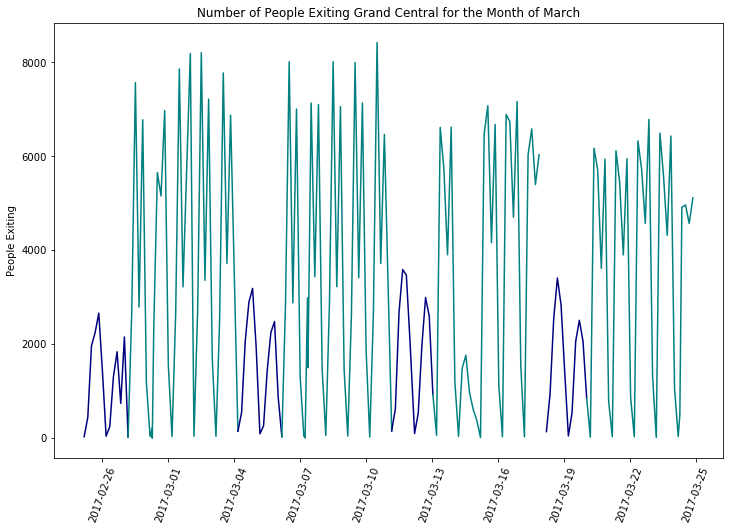

In [34]:
plt.figure(figsize=(12,8))

plt.xticks(rotation=70)
plt.plot(we1, color = 'navy')
plt.plot(wd1, color = '#008080')
plt.plot(we2, color = 'navy')
plt.plot(wd2, color = '#008080')
plt.plot(we3, color = 'navy')
plt.plot(wd3, color = '#008080')
plt.plot(we4, color = 'navy')
plt.plot(wd4, color = '#008080')
plt.title('Number of People Exiting Grand Central for the Month of March')
plt.ylabel('People Exiting')

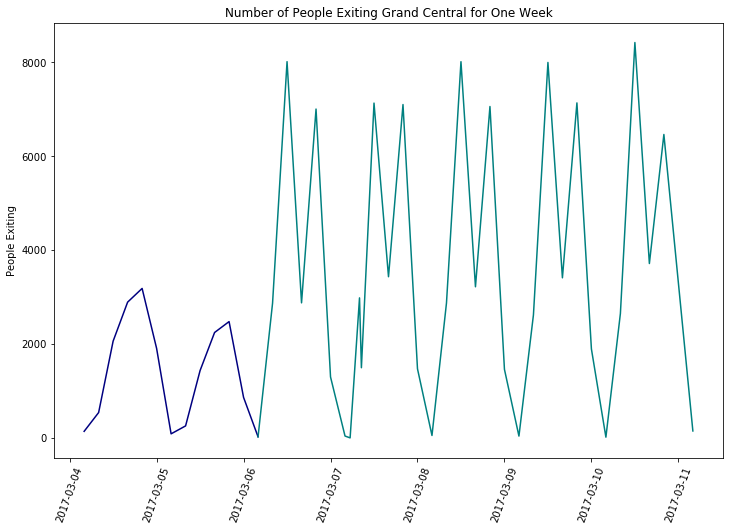

In [35]:
plt.figure(figsize=(12,8))


plt.xticks(rotation=70)
plt.plot(we2, color = 'navy')
plt.plot(wd2, color = '#008080')
plt.title('Number of People Exiting Grand Central for One Week')
plt.ylabel('People Exiting')

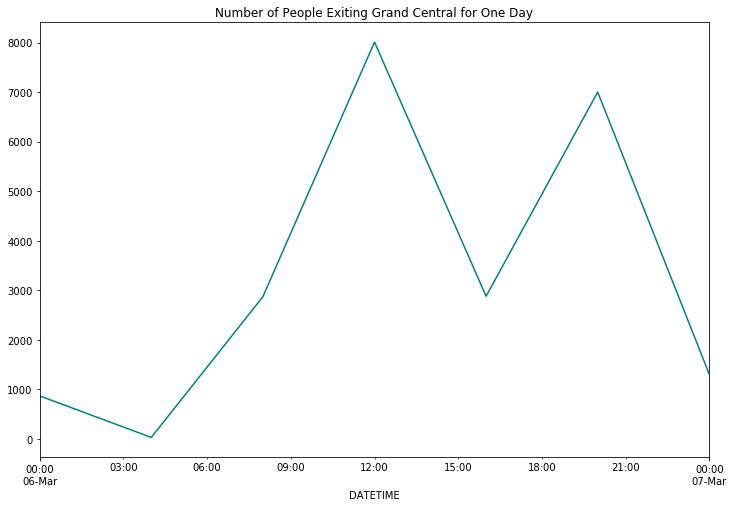

In [39]:
plt.figure(figsize=(12,8))


plt.xticks(rotation=200)
weekday1 = ct[(ct.index > '2017-03-05 21:00:00') & (ct.index < '2017-03-07 03:00:00')]
weekday1['DIFFS'].plot(title = 'Number of People Exiting Grand Central for One Day', color = '#008080' )

In [ ]:
# weekly plot without weekends separated

# wk1 = ct[(ct.index > '2017-02-25 00:00:00') & (ct.index < '2017-03-03 23:59:59')]
# wk2 = ct[(ct.index > '2017-03-04 00:00:00') & (ct.index < '2017-03-10 23:59:59')]
# wk3 = ct[(ct.index > '2017-03-11 00:00:00') & (ct.index < '2017-03-17 23:59:59')]
# wk4 = ct[(ct.index > '2017-03-18 00:00:00') & (ct.index < '2017-03-24 23:59:59')]
# plt.plot(wk1)
# plt.plot(wk2)
# plt.plot(wk3)
# plt.plot(wk4)

In [ ]:
# daily plots (too few points to be that useful)

# day1 = ct[(ct.index > '2017-02-25 00:00:00') & (ct.index < '2017-02-25 23:59:59')]
# day2 = ct[(ct.index > '2017-02-26 00:00:00') & (ct.index < '2017-02-26 23:59:59')]
# day3 = ct[(ct.index > '2017-02-27 00:00:00') & (ct.index < '2017-02-27 23:59:59')]
# day4 = ct[(ct.index > '2017-02-28 00:00:00') & (ct.index < '2017-02-28 23:59:59')]
# day5 = ct[(ct.index > '2017-03-01 00:00:00') & (ct.index < '2017-03-01 23:59:59')]
# day6 = ct[(ct.index > '2017-03-02 00:00:00') & (ct.index < '2017-03-02 23:59:59')]
# day7 = ct[(ct.index > '2017-03-03 00:00:00') & (ct.index < '2017-03-03 23:59:59')]
# plt.close()
# day1.plot()
# day2.plot()
# day3.plot()
# day4.plot()
# day5.plot()
# day6.plot()
# day7.plot()